# Neural Machine Translation Using Attention Model

`Encoder` encodes the complete information of the source sequence into a single real-valued vector , also known
as the context vector, which is passed to the `Decoder` to produce an output sequence , which is the target language like spanish.

The `Contex` vector has the responsibility to summarize the entire input sequence into a single vector, which is inefficient , so we use `Attention` mechanism.

The basic idea of `Attention` mechanism is to avoid attempting to learning a single vector representation for each sentence;instead, it pays attention to the specific input vectors of the input sequence based on the attention weights.

In [2]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time
import unicodedata

%matplotlib inline

### 1) Read the data from the file

In [3]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

### 2) Clean and Preprocess the source and target sentences

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(sentence):
  sentence = unicode_to_ascii(sentence.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)

  sentence = sentence.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  sentence = '<start> ' + sentence + ' <end>'
  return sentence

In [5]:
print(preprocess_sentence("Can you do it in one second?"))

<start> can you do it in one second ? <end>


#### Preprocess the source and target sentences to have  word pairs in format `[ENGLISH, SPANISH]`

In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [7]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


### 3) Tokenize the source and target sentences

We need to vectorize the text corpus where the text is conveted into a sequence of integers.

In [8]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [9]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

### 4) Create training and test dataset

split the dataset into  a test and train. 80% of data is used for training and 20% for testing the model

In [11]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


When the dataset is big, we want to create the dataset in memory to be efficient. We will use `tf.data.Dataset.from_tensor_slices()` method to get slices of array in the form of an object

In [12]:
# setting the batch size
BATCH_SIZE = 64
BUFFER_SIZE = len(input_tensor_train)

# create data in memory
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

# shuffles the data in batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [13]:
# Create an iterator for enumerating the elements of the dataset
source_batch, target_batch = next(iter(dataset))
print(source_batch.shape)
print(target_batch.shape)

(64, 11)
(64, 16)


In [14]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[1])

Input Language; index to word mapping
1 ----> <start>
20 ----> that
164 ----> wasn
12 ----> t
69 ----> good
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
143 ----> podria
6413 ----> mejorarse
3 ----> .
2 ----> <end>


In [16]:
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
source_vocab_size = len(inp_lang.word_index) + 1
target_vocab_size = len(targ_lang.word_index) + 1

### 5) Create the `Encoder`

The `encoder` takes the input as the source tokens, passes them to an `embedding` layer for the dense representation of the vector, which is then passed to `GRU`

Set `return_sequences` and `return_state` as True for the GRU. When the `return_sequences` set to true, then it returns the entire sequences of outputs from all the units in the encoder.
When `return_sequences` is set to False, then we only return the hidden state of the last encoder unit.

To return internal state of `GRU`, we set the `return_state` to True

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_units = encoder_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(encoder_units, return_sequences = True, return_state = True, recurrent_initializer = 'glorot_uniform')
        
    def call(self, x, hidden):
        # pass the input x to the embedding
        x = self.embedding(x)
        # pass the embedding  and the hidden state to the GRU
        output, state = self.gru(x, initial_state = hidden)
        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encoder_units))
        

In [20]:
encoder = Encoder(source_vocab_size, embedding_dim, units, BATCH_SIZE)

In [21]:
sample_hidden = encoder.initialize_hidden_state()

In [22]:
sample_output, sample_hidden = encoder(source_batch, sample_hidden)

In [23]:
print('Encoder output shape: (batch_size, sequence_length, units) {}'.format(sample_output.shape))
print('Encoder hidden state shape: (batch_size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch_size, sequence_length, units) (64, 11, 1024)
Encoder hidden state shape: (batch_size, units) (64, 1024)


### 6) Create the Bahdanau Attention layer

attention layer consist of
-> Alignment score
-> Attention weights
-> Context vector

In [24]:
class Attention(tf.keras.layers.Layer):
      def __init__(self, units):
          super(Attention, self).__init__()
          self.W1 = tf.keras.layers.Dense(units) # encoder output
          self.W2 = tf.keras.layers.Dense(units) # decoder hidden
          self.V = tf.keras.layers.Dense(1)

      def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1) #Returns a tensor with an additional dimension inserted at index axis.

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [25]:
attention_layer = Attention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


### 7) Create the Decoder

The Decoder has an `embedding` layer, a `GRU` layer, and a fully connected layer

To predict the target word Decoder uses
##### 1) Context vector: the sum of attention weights and encoder output
##### 2) Decoder output from the previous time step
##### 3) Previous decoder hidden state

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, decoder_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(decoder_units, return_sequences=True, return_state=True, recurrent_initializer = 'glorot_uniform')
        
        # Fully connected layer
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # attention
        self.attention = Attention(self.decoder_units)
        
    def call(self, x, hidden, encoder_output):
        context_vector, attention_weights = self.attention(hidden, encoder_output)
        
        # pass output sequence through input layers
        x = self.embedding(x)
        
        # concatenate context_vector and embedding for output sequence
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # pass the output through output layer
        x = self.fc(output)
        
        return x, state, attention_weights
        

In [27]:
decoder = Decoder(target_vocab_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 9414)


### 8) Define the optimizer and the loss function

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### 9) Train Dataset

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [30]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
        # create encoder
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        # first input to decode is start_
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        print(dec_input)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
          # passing enc_output to the decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
          
          # calculate loss based on prediction
          loss += loss_function(targ[:, t], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [31]:
EPOCHS = 1

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  
  # train the model using data in batches
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
Epoch 1 Batch 0 Loss 3.2613
Epoch 1 Batch 100 Loss 1.7069
Epoch 1 Batch 200 Loss 1.4418
Epoch 1 Batch 300 Loss 1.2672
Epoch 1 Loss 1.5599
Time taken for 1 epoch 1252.0504822731018 sec



### 10) Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [36]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [37]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [38]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [39]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> i am a boy . <end>
Predicted translation: no me gusta el . <end> 


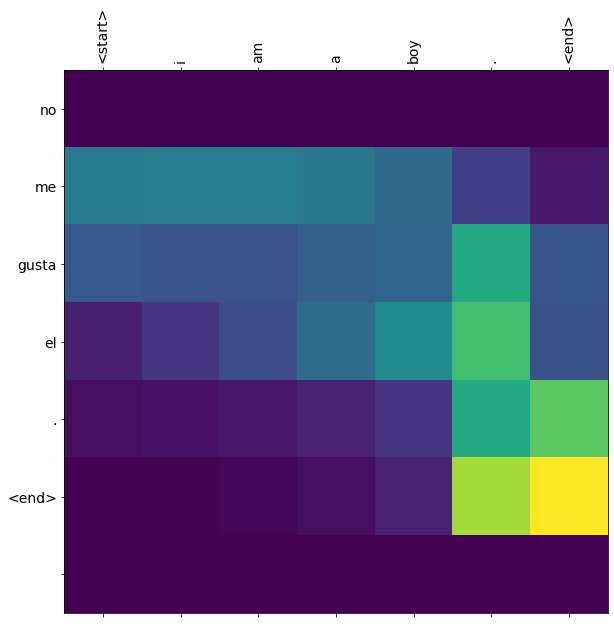

In [42]:
translate(u'i am a boy.')

Input: <start> slowly . <end>
Predicted translation: somos . <end> 


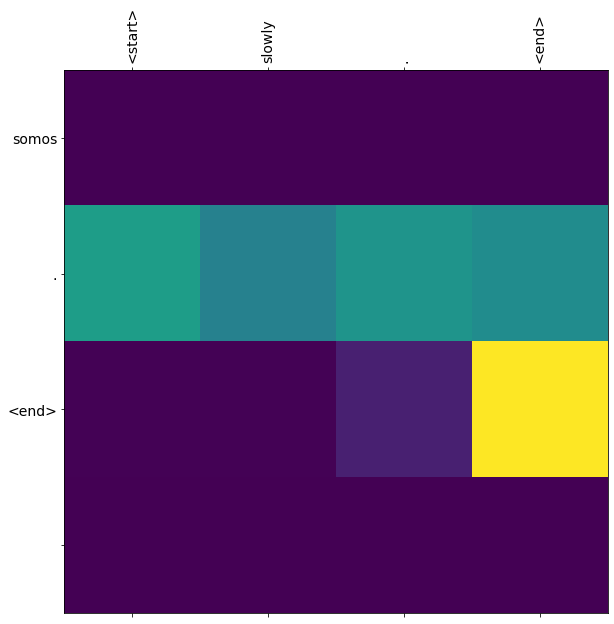

In [43]:
translate(u'slowly.')